In [94]:
import re
import math
import time
import codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import wraps
from datetime import datetime

from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KernelDensity

import keras.backend as K
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda, BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline

In [95]:
#TRAIN_DATA_PATH = Path('../input/nfl-big-data-bowl-2020/train.csv')
TRAIN_DATA_PATH = Path('/Users/samtaylor/Desktop/train.csv')
SEED = 0

In [96]:
train = pd.read_csv(TRAIN_DATA_PATH, dtype={'WindSpeed': 'object'})
train.head()

GameId          PlayId  Team      X      Y     S     A   Dis  \
0  2017090700  20170907000118  away  73.91  34.84  1.69  1.13  0.40   
1  2017090700  20170907000118  away  74.67  32.64  0.42  1.35  0.01   
2  2017090700  20170907000118  away  74.00  33.20  1.22  0.59  0.31   
3  2017090700  20170907000118  away  71.46  27.70  0.42  0.54  0.02   
4  2017090700  20170907000118  away  69.32  35.42  1.82  2.43  0.16   

   Orientation     Dir  ...  Week           Stadium        Location  \
0        81.99  177.18  ...     1  Gillette Stadium  Foxborough, MA   
1        27.61  198.70  ...     1  Gillette Stadium  Foxborough, MA   
2         3.01  202.73  ...     1  Gillette Stadium  Foxborough, MA   
3       359.77  105.64  ...     1  Gillette Stadium  Foxborough, MA   
4        12.63  164.31  ...     1  Gillette Stadium  Foxborough, MA   

   StadiumType        Turf     GameWeather Temperature Humidity  WindSpeed  \
0      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
1      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
2      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
3      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
4      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   

   WindDirection  
0             SW  
1             SW  
2             SW  
3             SW  
4             SW  

[5 rows x 49 columns]

In [97]:
replacements = [
    ('LSU', 'Louisiana State'),
    ('Southern California', 'USC'),
    ('Miami (Fla.)', 'Miami'),
    ('Miami, O.', 'Miami OH'),
    ('Miami (Ohio)', 'Miami OH'),
    ('Texas-El Paso', 'Texas')
]

In [98]:
college_to_conf = {
    'Air Force' : 'Mountain West Conference',
    'Akron' : 'Mid-American Conference',
    'Alabama' : 'Southeastern Conference',
    'Alabama-Birmingham' : 'Conference USA',
    'Appalachian State' : 'Sun Belt Conference',
    'Arizona' : 'Pacific 12 Conference',
    'Arizona State' : 'Pacific 12 Conference',
    'Arkansas' : 'Southeastern Conference',
    'Arkansas State' : 'Sun Belt Conference',
    'Army' : 'Independents',
    'Auburn' : 'Southeastern Conference',
    'Ball State' : 'Mid-American Conference',
    'Baylor' : 'Big 12 Conference',
    'Boise State' : 'Mountain West Conference',
    'Boston College' : 'Atlantic Coast Conference',
    'Bowling Green' : 'Mid-American Conference',
    'Brigham Young' : 'Independents',
    'Buffalo' : 'Mid-American Conference',
    'California' : 'Pacific 12 Conference',
    'Central Florida' : 'American Athletic Conference',
    'Central Michigan' : 'Mid-American Conference',
    'Cincinnati' : 'American Athletic Conference',
    'Clemson' : 'Atlantic Coast Conference',
    'Coastal Carolina' : 'Sun Belt Conference',
    'Colorado' : 'Pacific 12 Conference',
    'Colorado State' : 'Mountain West Conference',
    'Connecticut' : 'American Athletic Conference',
    'Duke' : 'Atlantic Coast Conference',
    'East Carolina' : 'American Athletic Conference',
    'Eastern Michigan' : 'Mid-American Conference',
    'Florida' : 'Southeastern Conference',
    'Florida Atlantic' : 'Conference USA',
    'Florida International' : 'Conference USA',
    'Florida State' : 'Atlantic Coast Conference',
    'Fresno State' : 'Mountain West Conference',
    'Georgia' : 'Southeastern Conference',
    'Georgia Southern' : 'Sun Belt Conference',
    'Georgia State' : 'Sun Belt Conference',
    'Georgia Tech' : 'Atlantic Coast Conference',
    'Hawai`i' : 'Mountain West Conference',
    'Houston' : 'American Athletic Conference',
    'Illinois' : 'Big 10 Conference',
    'Indiana' : 'Big 10 Conference',
    'Iowa' : 'Big 10 Conference',
    'Iowa State' : 'Big 12 Conference',
    'Kansas' : 'Big 12 Conference',
    'Kansas State' : 'Big 12 Conference',
    'Kent State' : 'Mid-American Conference',
    'Kentucky' : 'Southeastern Conference',
    'Liberty' : 'Independents',
    'Louisiana Tech' : 'Conference USA',
    'Louisiana-Lafayette' : 'Sun Belt Conference',
    'Louisiana-Monroe' : 'Sun Belt Conference',
    'Louisville' : 'Atlantic Coast Conference',
    'Louisiana State' : 'Southeastern Conference',
    'Marshall' : 'Conference USA',
    'Maryland' : 'Big 10 Conference',
    'Massachusetts' : 'Independents',
    'Memphis' : 'American Athletic Conference',
    'Miami' : 'Atlantic Coast Conference',
    'Miami OH' : 'Mid-American Conference',
    'Michigan' : 'Big 10 Conference',
    'Michigan State' : 'Big 10 Conference',
    'Middle Tennessee State' : 'Conference USA',
    'Minnesota' : 'Big 10 Conference',
    'Mississippi' : 'Southeastern Conference',
    'Mississippi State' : 'Southeastern Conference',
    'Missouri' : 'Southeastern Conference',
    'Navy' : 'American Athletic Conference',
    'Nebraska' : 'Big 10 Conference',
    'Nevada' : 'Mountain West Conference',
    'New Mexico' : 'Mountain West Conference',
    'New Mexico State' : 'Independents',
    'North Carolina' : 'Atlantic Coast Conference',
    'North Carolina State' : 'Atlantic Coast Conference',
    'North Texas' : 'Conference USA',
    'Northern Illinois' : 'Mid-American Conference',
    'Northwestern' : 'Big 10 Conference',
    'Notre Dame' : 'Independents',
    'Ohio State' : 'Big 10 Conference',
    'Ohio' : 'Mid-American Conference',
    'Oklahoma' : 'Big 12 Conference',
    'Oklahoma State' : 'Big 12 Conference',
    'Old Dominion' : 'Conference USA',
    'Oregon' : 'Pacific 12 Conference',
    'Oregon State' : 'Pacific 12 Conference',
    'Penn State' : 'Big 10 Conference',
    'Pittsburgh' : 'Atlantic Coast Conference',
    'Purdue' : 'Big 10 Conference',
    'Rice' : 'Conference USA',
    'Rutgers' : 'Big 10 Conference',
    'San Diego State' : 'Mountain West Conference',
    'San Jose State' : 'Mountain West Conference',
    'SMU' : 'American Athletic Conference',
    'South Alabama' : 'Sun Belt Conference',
    'South Carolina' : 'Southeastern Conference',
    'South Florida' : 'American Athletic Conference',
    'USC' : 'Pacific 12 Conference',
    'Southern Miss' : 'Conference USA',
    'Stanford' : 'Pacific 12 Conference',
    'Syracuse' : 'Atlantic Coast Conference',
    'Texas Christian' : 'Big 12 Conference',
    'Temple' : 'American Athletic Conference',
    'Tennessee' : 'Southeastern Conference',
    'Texas' : 'Big 12 Conference',
    'Texas A&M' : 'Southeastern Conference',
    'Texas State' : 'Sun Belt Conference',
    'Texas Tech' : 'Big 12 Conference',
    'Texas-San Antonio' : 'Conference USA',
    'Toledo' : 'Mid-American Conference',
    'Troy' : 'Sun Belt Conference',
    'Tulane' : 'American Athletic Conference',
    'Tulsa' : 'American Athletic Conference',
    'UCLA' : 'Pacific 12 Conference',
    'UNC-Charlotte' : 'Conference USA',
    'UNLV' : 'Mountain West Conference',
    'Utah' : 'Pacific 12 Conference',
    'Utah State' : 'Mountain West Conference',
    'UTEP' : 'Conference USA',
    'Vanderbilt' : 'Southeastern Conference',
    'Virginia' : 'Atlantic Coast Conference',
    'Virginia Tech' : 'Atlantic Coast Conference',
    'Wake Forest' : 'Atlantic Coast Conference',
    'Washington' : 'Pacific 12 Conference',
    'Washington State' : 'Pacific 12 Conference',
    'West Virginia' : 'Big 12 Conference',
    'Western Kentucky' : 'Conference USA',
    'Western Michigan' : 'Mid-American Conference',
    'Wisconsin' : 'Big 10 Conference',
    'Wyoming' : 'Mountain West Conference'
}

In [99]:
position_groups = {
    'CB' : 'DB',
    'FS' : 'DB',
    'SAF' : 'DB',
    'S' : 'DB',
    'SS' : 'DB',
    'DB' : 'DB',
    'OLB' : 'LB',
    'ILB' : 'LB',
    'MLB' : 'LB',
    'LB' : 'LB',
    'DE' : 'DL',
    'DT' : 'DL',
    'NT' : 'DL',
    'DL' : 'DL',
    'G' : 'OL',
    'OG' : 'OL',
    'T' : 'OL',
    'OT' : 'OL',
    'C' : 'OL',
    'RB' : 'RB',
    'FB' : 'RB',
    'HB' : 'RB',
    'WR' : 'SK',
    'QB' : 'SK',
    'TE' : 'SK'
}
posession_positions = {
    'DB': 0,
    'LB': 0,
    'DL': 0,
    'OL': 1,
    'RB': 1,
    'SK': 1
}

In [100]:
top25 = {
    'Air Force'  : 0,
    'Akron'  : 0,
    'Alabama'  : 1,
    'Alabama-Birmingham' : 0,
    'Appalachian State'  : 0,
    'Arizona'  : 0,
    'Arizona State'  : 0,
    'Arkansas'  : 0,
    'Arkansas State'  : 0,
    'Army'  : 0,
    'Auburn'  : 1,
    'Ball State'  : 0,
    'Baylor'  : 1,
    'Boise State'  : 1,
    'Boston College'  : 0,
    'Bowling Green'  : 0,
    'Brigham Young'  : 0,
    'Buffalo'  : 0,
    'California'  : 0,
    'Central Florida'  : 1,
    'Central Michigan'  : 0,
    'Cincinnati'  : 0,
    'Clemson'  : 1,
    'Coastal Carolina'  : 0,
    'Colorado'  : 0,
    'Colorado State'  : 0,
    'Connecticut'  : 0,
    'Duke'  : 0,
    'East Carolina'  : 0,
    'Eastern Michigan'  : 0,
    'Florida'  : 1,
    'Florida Atlantic'  : 0,
    'Florida International'  : 0,
    'Florida State'  : 0,
    'Fresno State'  : 0,
    'Georgia'  : 1,
    'Georgia Southern'  : 0,
    'Georgia State'  : 0,
    'Georgia Tech'  : 0,
    'Hawai`i'  : 0,
    'Houston'  : 0,
    'Illinois'  : 0,
    'Indiana'  : 0,
    'Iowa'  : 1,
    'Iowa State'  : 0,
    'Kansas'  : 0,
    'Kansas State'  : 0,
    'Kent State'  : 0,
    'Kentucky'  : 0,
    'Liberty'  : 0,
    'Louisiana Tech'  : 0,
    'Louisiana-Lafayette'  : 0,
    'Louisiana-Monroe'  : 0,
    'Louisville'  : 0,
    'Louisiana State'  : 1,
    'Marshall'  : 0,
    'Maryland'  : 0,
    'Massachusetts'  : 0,
    'Memphis'  : 0,
    'Miami'  : 1,
    'Miami OH'  : 0,
    'Michigan'  : 1,
    'Michigan State'  : 0,
    'Middle Tennessee State'  : 0,
    'Minnesota'  : 0,
    'Mississippi'  : 0,
    'Mississippi State'  : 0,
    'Missouri'  : 0,
    'Navy'  : 0,
    'Nebraska'  : 0,
    'Nevada'  : 0,
    'New Mexico'  : 0,
    'New Mexico State'  : 0,
    'North Carolina'  : 0,
    'North Carolina State'  : 0,
    'North Texas'  : 0,
    'Northern Illinois'  : 0,
    'Northwestern'  : 1,
    'Notre Dame'  : 1,
    'Ohio State'  : 1,
    'Ohio'  : 0,
    'Oklahoma'  : 1,
    'Oklahoma State'  : 1,
    'Old Dominion'  : 0,
    'Oregon'  : 1,
    'Oregon State'  : 0,
    'Penn State'  : 1,
    'Pittsburgh'  : 0,
    'Purdue'  : 0,
    'Rice'  : 0,
    'Rutgers'  : 0,
    'San Diego State'  : 0,
    'San Jose State'  : 0,
    'SMU'  : 0,
    'South Alabama'  : 0,
    'South Carolina'  : 0,
    'South Florida'  : 0,
    'USC'  : 1,
    'Southern Miss'  : 0,
    'Stanford'  : 0,
    'Syracuse'  : 0,
    'Texas Christian'  : 0,
    'Temple'  : 0,
    'Tennessee'  : 0,
    'Texas'  : 1,
    'Texas A&M'  : 1,
    'Texas State'  : 0,
    'Texas Tech'  : 0,
    'Texas-San Antonio'  : 0,
    'Toledo'  : 0,
    'Troy'  : 0,
    'Tulane'  : 0,
    'Tulsa'  : 0,
    'UCLA'  : 0,
    'UNC-Charlotte'  : 0,
    'UNLV'  : 0,
    'Utah'  : 0,
    'Utah State'  : 0,
    'UTEP'  : 0,
    'Vanderbilt'  : 0,
    'Virginia'  : 0,
    'Virginia Tech'  : 0,
    'Wake Forest'  : 0,
    'Washington'  : 1,
    'Washington State'  : 1,
    'West Virginia'  : 0,
    'Western Kentucky'  : 0,
    'Western Michigan'  : 0,
    'Wisconsin'  : 1,
    'Wyoming'  : 0
}

In [101]:
COLS_TO_DROP = [
    'Position', 'IsRusher'
]
CATEGORICAL_VARS = [
    'DisplayName', 'PlayerCollegeName', 'GameWeather', 'Location',
    'OffensePersonnel', 'Stadium', 'WindDirection', 'DefensePersonnel',
    'HomeTeamAbbr', 'VisitorTeamAbbr', 'FieldPosition', 'PossessionTeam',
    'StadiumType', 'Position', 'Turf', 'PlayerHeight', 'OffenseFormation',
    'JerseyNumber', 'NflId'
]
TRANSFORMED_CATEGORICALS = [
    'OffensePersonnel', 'DefensePersonnel', 'WindSpeed', 'PlayerHeight',
    'NflId', 'Turf', 'FieldPosition', 'PlayerCollegeName', 'JerseyNumber',
    'PossessionTeam'
]
VARS_TO_ONE_HOT = [var for var in CATEGORICAL_VARS
                   if var not in TRANSFORMED_CATEGORICALS
                   and var not in COLS_TO_DROP]
MAX_CARDINALITY = 24

In [102]:
cardinalities = train[VARS_TO_ONE_HOT].nunique().sort_values(ascending=False)
cardinalities

DisplayName         2230
GameWeather           61
Location              60
Stadium               55
WindDirection         53
VisitorTeamAbbr       32
HomeTeamAbbr          32
StadiumType           29
OffenseFormation       8
dtype: int64

In [103]:
def shoelace(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [104]:
def func_timer(fn):
    @wraps(fn)
    def timer(*args, **kwargs):
        print('\n' + fn.__name__.upper())
        start_time = datetime.now()
        res = fn(*args, **kwargs)
        end_time = datetime.now()
        time_taken = end_time - start_time
        time_taken = time_taken.total_seconds() / 60
        print('{} time taken: {:.2f} mins'.format(fn.__name__, time_taken))
        return res
    return timer

def transformation_check(fn):
    @wraps(fn)
    def checker(*args, **kwargs):
        print(' -- {} -- '.format(fn.__name__))
        res = fn(*args, **kwargs)
        end_shape = res.shape
        null_prc = 100 * (res.isnull().sum() / len(res)).mean()
        print('\tshape = {}'.format(end_shape))
        print('\tnull % = {:.2f}'.format(null_prc))
        return res
    return checker

In [105]:
class Preprocessor(TransformerMixin):
    def __init__(self, one_hot_vars, max_cardinality, cols_to_drop=[]):
        super().__init__()
        self.target = 'Yards'
        self.one_hot_vars = one_hot_vars
        self.max_cardinality = max_cardinality
        self.cols_to_drop = cols_to_drop
        self.player_cols = []
        self.one_hot_encoder = OneHotEncoder(
            sparse=False, 
            dtype=np.int, 
            handle_unknown='ignore'
        )
        self.college_encoding = {}
        self.jersey_encoding = {}

    @func_timer
    def initial_cleaning(self, X):
        """ Transformative steps that don't need any 'fitted'
        objects. Also any thing that needs to be done before anything
        is fit """
        X = self._correct_team_abbreviations(X)
        X = self._encode_player_height(X)
        X = self._process_time_variables(X)
        X = self._fix_wind_variables(X)
        X = self._fix_stadium_type_and_turf(X)
        X = self._map_college_and_pos(X)
        X = self._encode_personnel(X)
        X = self._normalise_positional_data(X)
        X = self._calc_voronoi(X)
        X = self._misc_engineering(X)
        X.drop(columns=self.cols_to_drop, inplace=True)
        return X

    @func_timer
    def fit(self, X, y=None):
        # Get player related columns
        self._get_player_cols(X)

        # Fit one hot encoder
        cardinalities = X[self.one_hot_vars].nunique().to_dict()
        one_hot_vars = [var for var in self.one_hot_vars
                        if cardinalities[var] <= self.max_cardinality]
        self.one_hot_encoder.fit(X[one_hot_vars].fillna('unknown'))
        self.oh_cols_to_drop = [var for var in self.one_hot_vars
                                if var not in one_hot_vars]
        self.one_hot_vars = one_hot_vars
        
        # Fit college name and jersey number 'encoder's
        self.college_encoding = \
            X.groupby('PlayerCollegeName')['PlayId'].count().to_dict()
        self.jersey_encoding = \
            X.groupby('JerseyNumber')['PlayId'].count().to_dict()
        
        return self

    @func_timer
    def transform(self, X):
        X['PlayerCollegeName'] = X['PlayerCollegeName'].map(self.college_encoding)
        X['PlayerCollegeNameRusher'] = \
            X['PlayerCollegeNameRusher'].map(self.college_encoding)
        X['JerseyNumber'] = X['JerseyNumber'].map(self.jersey_encoding)
        X = self._apply_one_hot_encoder(X)
        X = self._flatten_player_vars(X)
#         X = self._previous_play_data(X)
        return X

    @transformation_check
    def _correct_team_abbreviations(self, X):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in X['PossessionTeam'].unique():
            map_abbr[abb] = abb

        X['PossessionTeam'] = X['PossessionTeam'].map(map_abbr)
        X['HomeTeamAbbr'] = X['HomeTeamAbbr'].map(map_abbr)
        X['VisitorTeamAbbr'] = X['VisitorTeamAbbr'].map(map_abbr)
        return X

    @transformation_check
    def _encode_player_height(self, X):
        def string_to_inches(x):
            feet, inch = x.split('-')
            return int(inch) + 12 * int(feet)

        X['PlayerHeight'] = X['PlayerHeight'].apply(string_to_inches)
        return X

    @transformation_check
    def _process_time_variables(self, X):
        for col in ['TimeHandoff', 'TimeSnap', 'PlayerBirthDate']:
            X[col] = pd.to_datetime(X[col], utc=True, infer_datetime_format=True)
        X['TimeUntilHandoff'] = X['TimeSnap'] - X['TimeHandoff']
        X['TimeUntilHandoff'] = X['TimeUntilHandoff'].dt.total_seconds()

        X['PlayerAge'] = X['TimeSnap'] - X['PlayerBirthDate']
        X['PlayerAge'] = X['PlayerAge'].dt.total_seconds() / 31556952

        X['GameClock'] = 360 * X['GameClock'].str[:2].astype(int) \
                         + 60 * X['GameClock'].str[3:5].astype(int) \
                         + X['GameClock'].str[6:8].astype(int)
        
        X['SecondsRemaining'] = 0
        X.loc[X['Quarter'] == 1, 'SecondsRemaining'] = 45 * 60 + X['GameClock']
        X.loc[X['Quarter'] == 2, 'SecondsRemaining'] = 30 * 60 + X['GameClock']
        X.loc[X['Quarter'] == 3, 'SecondsRemaining'] = 15 * 60 + X['GameClock']
        X.loc[X['Quarter'] == 4, 'SecondsRemaining'] = 0 * 60 + X['GameClock']
        X.loc[X['Quarter'] == 5, 'SecondsRemaining'] = 0 * 60 + X['GameClock']

        X.drop(columns=['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], inplace=True)
        return X

    @transformation_check
    def _fix_wind_variables(self, X):
        def average_ranges(x):
            x = str(x)
            if '-' in x:
                low, high = x.split('-')
                return str((int(high) + int(low)) / 2)
            elif ' gusts up to ' in x:
                low, high = x.split(' gusts up to ')
                return str((int(high) + int(low)) / 2)
            else:
                return x

        def coerce_to_int(x):
            try:
                x = int(x)
            except:
                x = np.nan
            return x

        X['WindSpeed'] = X['WindSpeed'].str.lower().str.replace('mph', '')
        X['WindSpeed'] = X['WindSpeed'].str.strip()
        X['WindSpeed'] = X['WindSpeed'].apply(average_ranges)
        X['WindSpeed'] = X['WindSpeed'].apply(coerce_to_int)

        acceptable_directions = [
            'NE', 'SW', 'S', 'NW', 'WSW', 'SE', 'W', 'N', 'NNE', 'WNW', 'SSW',
            'NNW', 'SSE', 'E', 'ENE', 'ESE'
        ]
        X['WindDirection'] = X['WindDirection'].str.upper()
        X['WindDirection'] = X['WindDirection'].str.replace('FROM ', '').str.replace('-', '')
        X.loc[~X['WindDirection'].isin(acceptable_directions), 'WindDirection'] = np.nan
        return X
    
    @transformation_check
    def _fix_stadium_type_and_turf(self, X):
        stadium_type_map = {
            'Outdoor': 'Outdoor',
            'Outdoors': 'Outdoor',
            'Indoors': 'Indoor',
            'Dome': 'Indoor',
            'Indoor': 'Indoor',
            'Retractable Roof': 'Retr Open',
            'Open': 'Retr Open',
            'Retr. Roof-Closed': 'Retr Closed',
            'Retr. Roof - Closed': 'Retr Closed',
            'Domed, closed': 'Retr Closed',
            'Domed, open': 'Retr Open',
            'Closed Dome': 'Retr Closed',
            'Dome, closed': 'Retr Closed',
            'Domed': 'Indoor',
            'Oudoor': 'Outdoor',
            'Indoor, Roof Closed': 'Retr Closed',
            'Retr. Roof Closed': 'Retr Closed',
            'Retr. Roof-Open': 'Retr Open',
            'Bowl': 'Outdoor',
            'Outddors': 'Outdoor',
            'Heinz Field': 'Outdoor',
            'Outdoor Retr Roof-Open': 'Retr Open',
            'Retr. Roof - Open': 'Retr Open',
            'Indoor, Open Roof': 'Retr Open',
            'Ourdoor': 'Outdoor',
            'Outdor': 'Outdoor',
            'Outside': 'Outdoor',
            'Cloudy': 'Outdoor',
            'Domed, Open': 'Retr Open'
        }
        X['StadiumType'] = X['StadiumType'].map(stadium_type_map)
        
        grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
        X['Turf'] = np.where(X['Turf'].str.lower().isin(grass_labels), 1, 0)
        
        def get_city(x):
            x = x.replace('e.', 'east').replace('.', ',')
            return x.split(',')[0].strip().lower()
        X['Location'] = X['Location'].apply(get_city)
        
        return X
    
    @transformation_check
    def _map_college_and_pos(self, X):
        for replacement in replacements:
            X['PlayerCollegeName'] = X['PlayerCollegeName']\
                .replace(replacement[0], replacement[1])
        X['CollegeConference'] = X['PlayerCollegeName'].map(college_to_conf)
        X['CollegeConference'].fillna('BinJuice', inplace=True)
        if 'CollegeConference' not in self.one_hot_vars:
            self.one_hot_vars += ['CollegeConference']
        
        X['PlayerCollegeName'] = X['PlayerCollegeName']\
                .replace(replacement[0], replacement[1])
        X['Top25'] = X['PlayerCollegeName'].map(top25)
        X['Top25'].fillna(0, inplace=True)
        
        X['PositionGroup'] = X['Position'].map(position_groups)
        X['InPossesion'] = X['PositionGroup'].map(posession_positions)
        return X

    @transformation_check
    def _encode_personnel(self, X):

        def count_positions(x, offensive):
            offensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0, 'QB': 0, 'RB': 0, 'TE': 0, 'WR': 0}
            defensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0}
            if offensive:
                val_counts=offensive_counts
            else:
                val_counts=defensive_counts

            if isinstance(x, str):
                for position_val in x.split(','):
                    val, pos = position_val.strip().split(' ')
                    if pos in val_counts:
                        val_counts[pos] += int(val)
            return val_counts
        
        X['OffensePersonnel'] = X['OffensePersonnel'] \
            .apply(count_positions, offensive=True)
        off_personnel_df = pd.DataFrame().from_records(X['OffensePersonnel'].values)
        off_personnel_df.index = X.index
        off_personnel_df.columns = ['NOffensive' + col for col in off_personnel_df.columns]

        X['DefensePersonnel'] = X['DefensePersonnel'] \
            .apply(count_positions, offensive=False)
        def_personnel_df = pd.DataFrame().from_records(X['DefensePersonnel'].values)
        def_personnel_df.index = X.index
        def_personnel_df.columns = ['NDefensive' + col for col in def_personnel_df.columns]

        X.drop(columns=['OffensePersonnel', 'DefensePersonnel'], inplace=True)
        X = pd.concat([X, off_personnel_df, def_personnel_df], axis=1)
        return X
    
    @transformation_check
    def _normalise_positional_data(self, X):
        X['IsLeftDirection'] = X['PlayDirection'] == 'left'
        
        X['PossesionInOwnHalf'] = X['PossessionTeam'] == X['FieldPosition']
        possession_in_own_half = X.groupby(['GameId', 'PlayId'])['PossesionInOwnHalf'].max().reset_index()
        X = X.drop(columns='PossesionInOwnHalf')\
            .merge(possession_in_own_half, on=['GameId', 'PlayId'])
        
        X['DistToEndZone'] = X['YardLine']
        X.loc[X['PossesionInOwnHalf'], 'DistToEndZone'] = 50 + (50 - X['YardLine'])
        X.loc[X['YardLine'] == 50, 'DistToEndZone'] = 50
        X['YardLineStd'] = 100 - X['DistToEndZone']
        
        X['XStd'] = X['X']
        X.loc[X['IsLeftDirection'], 'XStd'] = 120 - X.loc[X['IsLeftDirection'], 'X']
        
        X['YStd'] = X['Y']
        X.loc[X['IsLeftDirection'], 'YStd'] = 160 / 3 - X.loc[X['IsLeftDirection'], 'Y']
        
        X['PlayerDistToEndZone'] = 100 - (X['XStd'] - 10)
        
        X['DirRad'] = np.mod(90 - X['Dir'], 360) * math.pi / 180.0
        X['DirStd'] = X['DirRad']
        X.loc[X['IsLeftDirection'], 'DirStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'DirRad'], 2*np.pi)
        
        # Fix the problem with orientation over the years
        X['OrientationRad'] = np.mod(X['Orientation'], 360) * math.pi / 180.0
        X.loc[X['Season'] >= 2018, 'OrientationRad'] \
            = np.mod(X.loc[X['Season'] >= 2018, 'Orientation'] - 90, 360) * math.pi / 180.0
        
        X['OrientationStd'] = X['OrientationRad']
        X.loc[X['IsLeftDirection'], 'OrientationStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'OrientationRad'], 2 * np.pi)
        X.drop(columns=['OrientationRad'], inplace=True)
        
        X['IsLeftDirection'] = (X['IsLeftDirection']).astype(int)
        X['IsRusher'] = (X['NflId'] == X['NflIdRusher']).astype(int)
        return X
    
    @transformation_check
    def _calc_voronoi(self, X):
        max_voronoi = 120 * 53.3
        X['VoronoiArea'] = 0
        X['VoronoiAreaNoOffence'] = 0
        for play_id in X['PlayId'].unique():
            play = X.loc[X['PlayId'] == play_id].copy()

            # Only consider space 5 yards behind the player furthest back
            x_cut_off = play['XStd'].min() - 5

            # Also calculate the rusher's voronoi excluding team mates
            no_offence_play = play[play['IsRusher'].astype(bool) |
                                   ~play['InPossesion'].astype(bool)]

            def mirror_boundary(xy):
                xy = xy.values
                n_points = xy.shape[0]
                xy1 = xy.copy()
                xy1[:,1] = -xy[:,1]
                xy2 = xy.copy()
                xy2[:,1] = 320/3 - xy[:,1]
                xy3 = xy.copy()
                xy3[:,0] = 2 * x_cut_off - xy[:,0]
                xy4 = xy.copy()
                xy4[:,0] = 220 - xy[:,0]
                return np.concatenate((xy, xy1, xy2, xy3, xy4), axis=0), n_points

            # Get voronoi
            xy, n = mirror_boundary(play[['XStd', 'YStd']])
            vor = Voronoi(xy)

            no_off_xy, _ = mirror_boundary(no_offence_play[['XStd', 'YStd']])
            no_off_vor = Voronoi(no_off_xy)

            # Calculate space area
            areas = np.zeros([play.shape[0], ])
            for i in range(n):
                player_point = vor.point_region[i]
                vertices = vor.vertices[vor.regions[player_point]]
                areas[i] = shoelace(vertices[:, 0], vertices[:, 1])

            rusher_index = np.argmax(no_offence_play['IsRusher'].values)
            rusher_index_in_df = no_offence_play.index.values[rusher_index]
            rusher_region = no_off_vor.point_region[rusher_index]
            rusher_vertex_index = no_off_vor.regions[rusher_region]
            rusher_vertices = no_off_vor.vertices[rusher_vertex_index]
            rusher_area = shoelace(rusher_vertices[:, 0], rusher_vertices[:, 1])

            # Assign to main df
            X.loc[play.index, 'VoronoiArea'] = areas
            X.loc[rusher_index_in_df, 'VoronoiAreaNoOffence'] = min(rusher_area, max_voronoi)
            
        X.loc[X['VoronoiArea'] > max_voronoi, 'VoronoiArea'] = max_voronoi
        return X

    @transformation_check
    def _misc_engineering(self, X):
        X['ScoreDiff'] = X['HomeScoreBeforePlay'] - X['VisitorScoreBeforePlay']
        # Set binary variables
        X['IsAwayTeam'] = (X['Team'] == 'away').astype(int)
        X['IsInAwayEnd'] = (X['FieldPosition'] == X['VisitorTeamAbbr']).astype(int)
        X['HomePossesion'] = (X['PossessionTeam'] == X['HomeTeamAbbr']).astype(int)
        X['AwayInPosession'] = (X['InPossesion'] == X['IsAwayTeam']).astype(int)
        # Directional features
        X['SX'] = X['S'] * np.cos(X['DirStd'])
        X['SY'] = X['S'] * np.sin(X['DirStd'])
        X['AX'] = X['A'] * np.cos(X['DirStd'])
        X['AY'] = X['A'] * np.sin(X['DirStd'])
        X['OrientationCos'] = X['OrientationStd'] * np.cos(X['DirStd'])
        X['OrientationSin'] = X['OrientationStd'] * np.sin(X['DirStd'])
        # Closeness to scrimmage line
        X['XToScrimmage'] = X['YardLineStd'] - (X['XStd'] - 10)
        
        # Get Rusher features
        rusher_pos = X.loc[
            X['IsRusher'] == 1, 
            ['XStd', 'YStd', 'DirStd', 'S', 'SX', 'SY', 'A', 'AX', 'AY', 
             'Position', 'GameId', 'PlayId', 'PlayerCollegeName', 'Dis',
             'XToScrimmage', 'PlayerDistToEndZone', 'OrientationStd', 'OrientationCos',
             'OrientationSin', 'VoronoiArea', 'VoronoiAreaNoOffence']
        ]
        X = X.merge(rusher_pos, on=['GameId', 'PlayId'], suffixes=['', 'Rusher'])
        if 'PositionRusher' not in self.one_hot_vars:
            self.one_hot_vars += ['PositionRusher']
        
        # Relationship of other players to rusher
        X['XFromRusher'] = abs(X['XStd'] - X['XStdRusher'])
        X['YFromRusher'] = abs(X['YStd'] - X['YStdRusher'])
        X['DistFromRusher'] = np.sqrt(np.square(X['XFromRusher']) 
                                      + np.square(X['YFromRusher'])) 
        
        X['TimeToRusher'] = X['DistFromRusher'] / X['S']
        X.loc[np.isinf(X['TimeToRusher']), 'TimeToRusher'] = 1000
        
        # Force and momentum
        X['Force'] = X['PlayerWeight'] * X['A']
        X['Momentum'] = X['PlayerWeight'] * X['S']
        
        cols_to_drop = ['NflId', 'NflIdRusher', 'Team', 'PlayDirection', 
                        'FieldPosition', 'PossessionTeam', 'OrientationCos',
                        'OrientationSin', 'VoronoiAreaNoOffence', 
                        'PlayerDistToEndZone']
        X.drop(columns=cols_to_drop, inplace=True)
        return X
    
    @transformation_check
    def _apply_one_hot_encoder(self, X):
        col_names = []
        print('\tdropping columns: {} for having cardinality > {}'
              .format(' '.join(self.oh_cols_to_drop), self.max_cardinality))
        X.drop(columns=self.oh_cols_to_drop, inplace=True)
        self.player_cols = [col for col in self.player_cols
                            if col not in self.oh_cols_to_drop]
        print('\tone hot encoding columns: {}'.format(' '.join(self.one_hot_vars)))
        X_1h = self.one_hot_encoder.transform(X[self.one_hot_vars].fillna('unknown'))

        for i, col in enumerate(self.one_hot_vars):
            new_var_names = \
                [col + '_' + val for val in self.one_hot_encoder.categories_[i]]
            col_names += new_var_names
            if col in self.player_cols:
                self.player_cols.remove(col)
                self.player_cols += new_var_names

        X_1h = pd.DataFrame(data=X_1h, index=X.index, columns=col_names)
        X = pd.concat([X.drop(columns=self.one_hot_vars), X_1h], axis=1)
        return X

    @transformation_check
    def _flatten_player_vars(self, X):
        
        # Cols to group
        college_mask = ['CollegeConference' in col for col in X.columns]
        college_cols = X.columns[college_mask]
        college_agg = X.groupby(['GameId', 'PlayId'])[college_cols].sum()
        X.drop(columns=college_cols, inplace=True)
        
        mechanics_cols = [
            'X', 'XStd', 'Y', 'YStd', 'A', 'S', 'Dir', 'DirRad', 'DirStd',
            'PlayerHeight', 'PlayerWeight', 'PlayerAge', 'Force',
            'Momentum', 'OrientationStd', 'Dis', 'XFromRusher', 'XToScrimmage',
            'YFromRusher', 'DistFromRusher', 'AX', 'AY', 'SX', 'SY', 'TimeToRusher'
        ]
        mech_agg = X.groupby(['GameId', 'PlayId', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.reset_index(inplace=True)
        mech_agg.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg['InPossesion'] = mech_agg['InPossesion'].map({1: 'off', 0: 'def'})
        mech_agg = mech_agg.pivot(columns='InPossesion')
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.fillna(0, inplace=True)
        
        college_like_cols = [
            'PlayerCollegeName', 'JerseyNumber'
        ]
        coll_mean = X.groupby(['GameId', 'PlayId', 'InPossesion'])[college_like_cols]\
            .agg(['mean'])
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.reset_index(inplace=True)
        coll_mean.set_index(['GameId', 'PlayId'], inplace=True)
        coll_mean['InPossesion'] = coll_mean['InPossesion'].map({1: 'off', 0: 'def'})
        coll_mean = coll_mean.pivot(columns='InPossesion')
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.fillna(0, inplace=True)
        
        X.drop(columns=college_like_cols, inplace=True)
        
        top_25_col = ['Top25']

        top_25_pos = X.groupby(['GameId', 'PlayId', 'PositionGroup', 'InPossesion'])[top_25_col]\
            .agg(['sum'])
        top_25_pos.columns = ['_'.join(col).strip() for col in top_25_pos.columns.values]
        top_25_pos.reset_index(inplace=True)
        top_25_pos.set_index(['GameId', 'PlayId'], inplace=True)
        top_25_pos['PositionPossession'] = top_25_pos['InPossesion'].map({1: 'off', 0: 'def'}) \
            + '_' + top_25_pos['PositionGroup']
        top_25_pos.drop(columns=['InPossesion', 'PositionGroup'], inplace=True)
        top_25_pos = top_25_pos.pivot(columns='PositionPossession')
        top_25_pos.columns = ['_'.join(col).strip() for col in top_25_pos.columns.values]
        top_25_pos.fillna(0, inplace=True)
        
        X.drop(columns=top_25_col, inplace=True)
        
        mechanics_cols += ['VoronoiArea']
        mech_agg_pos = X.groupby(['GameId', 'PlayId', 'PositionGroup', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.reset_index(inplace=True)
        mech_agg_pos.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg_pos['PositionPossession'] = mech_agg_pos['InPossesion'].map({1: 'off', 0: 'def'}) \
            + '_' + mech_agg_pos['PositionGroup']
        mech_agg_pos.drop(columns=['InPossesion', 'PositionGroup'], inplace=True)
        mech_agg_pos = mech_agg_pos.pivot(columns='PositionPossession')
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.fillna(0, inplace=True)
        
        X.drop(columns=mechanics_cols, inplace=True)
        
        away_ind = X.groupby(['GameId', 'PlayId'])['AwayInPosession', 'ScoreDiff'].max()
        away_ind['PosessionTeamLeading'] = 0
        mask = ((away_ind['AwayInPosession'] == 1) & (away_ind['ScoreDiff'] < 0)) | \
            ((away_ind['AwayInPosession'] == 0) & (away_ind['ScoreDiff'] > 0))
        away_ind.loc[mask, 'PosessionTeamLeading'] = 1
        away_ind['PosessionTeamLead'] = away_ind['ScoreDiff']
        away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead'] = \
            -away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead']
        away_ind['GameWithinConvTouchdown'] = away_ind['ScoreDiff'].abs() <= 8
        
        # Cols to ignore
        ignore_cols = ['IsAwayTeam', 'InPossesion', 'AwayInPosession', 
                       'PositionGroup', 'ScoreDiff', 'Orientation']
        X.drop(columns=ignore_cols, inplace=True)
        
        # Cols to spread wide
        self.player_cols = [col for col in self.player_cols 
                            if col not in college_cols
                            and col not in mechanics_cols
                            and col not in college_like_cols
                            and col not in top_25_col
                            and col not in ignore_cols]
        n_player_cols = len(self.player_cols)
        if self.player_cols:
            player_data = X[self.player_cols].values.reshape(-1, n_player_cols * 22)
            new_col_names = [col + '_' + str(player_num)
                             for player_num in range(22)
                             for col in self.player_cols]

            player_data = pd.DataFrame(
                data=player_data,
                columns=new_col_names
            )
            player_data = player_data.infer_objects()

        X.drop(columns=self.player_cols, inplace=True)
        X = X.drop_duplicates().reset_index(drop=True)
        
        if self.player_cols:
            X = pd.concat([X, player_data], axis=1)
            
        X.set_index(['GameId', 'PlayId'], inplace=True)
        X = X.merge(college_agg, how='left', left_index=True, right_index=True, suffixes=['', 'College'])
        X = X.merge(mech_agg, how='left', left_index=True, right_index=True, suffixes=['', 'TeamMech'])
        X = X.merge(coll_mean, how='left', left_index=True, right_index=True, suffixes=['', 'PlayerCollege'])
        X = X.merge(mech_agg_pos, how='left', left_index=True, right_index=True, suffixes=['', 'TeamPosMech'])
        X = X.merge(away_ind, how='left', left_index=True, right_index=True, suffixes=['', 'GameInds'])   
        return X
    
    @transformation_check
    def _previous_play_data(self, X):
        X[['YardLineLastRush', 'GameClockLastRush', 'DistanceLastRush']] = \
            X.groupby(['GameId', 'PlayId'])['YardLineStd', 'GameClock', 'Distance'].shift()
        X['TimeSinceLastRush'] = X['GameClock'] - X['GameClockLastRush']
        X.drop(columns=['YardLineLastRush', 'GameClockLastRush', 'DistanceLastRush'], inplace=True)
        return X
    
    def _get_player_cols(self, X):
        max_vals = X.groupby(['GameId', 'PlayId']).nunique().max()
        self.player_cols = max_vals[max_vals > 1].index.tolist()
        self.team_cols = max_vals[max_vals == 2].index.tolist()

In [106]:
class DropColinear(TransformerMixin):
    def __init__(self, max_corr=1):
        self.max_corr = max_corr
        self.all_corellated_cols = []
        
    def fit(self, X, y=None):
        corr = X.corr()
        corr = pd.DataFrame(np.triu(corr), columns=corr.columns, index=corr.index)
        for col in corr.index:
            correlated_cols = corr.columns[corr[col].abs() >= self.max_corr].tolist()
            correlated_cols = [c_col for c_col in correlated_cols if c_col != col]
            if correlated_cols:
                self.all_corellated_cols += correlated_cols
        self.all_corellated_cols = np.unique(self.all_corellated_cols)
        return self
    
    def transform(self, X):
        print('Dropping following columns for having a correlation of over {} with '
              'another variable:\n{}'.format(self.max_corr, ', '.join(self.all_corellated_cols)))
        X.drop(columns=self.all_corellated_cols, inplace=True)
        return X

In [107]:
processor = Preprocessor(
    one_hot_vars=VARS_TO_ONE_HOT,
    max_cardinality=MAX_CARDINALITY,
    cols_to_drop=COLS_TO_DROP
)
print(train.shape)
train = processor.initial_cleaning(train)
train = processor.fit_transform(train)

(509762, 49)

INITIAL_CLEANING
 -- _correct_team_abbreviations -- 
	shape = (509762, 49)
	null % = 1.14
 -- _encode_player_height -- 
	shape = (509762, 49)
	null % = 1.14
 -- _process_time_variables -- 
	shape = (509762, 49)
	null % = 1.14
 -- _fix_wind_variables -- 
	shape = (509762, 49)
	null % = 1.53
 -- _fix_stadium_type_and_turf -- 
	shape = (509762, 49)
	null % = 1.53
 -- _map_college_and_pos -- 
	shape = (509762, 53)
	null % = 1.42
 -- _encode_personnel -- 
	shape = (509762, 63)
	null % = 1.19
 -- _normalise_positional_data -- 
	shape = (509762, 74)
	null % = 1.02
 -- _calc_voronoi -- 
	shape = (509762, 76)
	null % = 0.99
 -- _misc_engineering -- 
	shape = (509762, 103)
	null % = 0.72
initial_cleaning time taken: 11.66 mins

FIT
fit time taken: 0.16 mins

TRANSFORM
 -- _apply_one_hot_encoder -- 
	dropping columns: DisplayName GameWeather Location Stadium HomeTeamAbbr VisitorTeamAbbr for having cardinality > 24
	one hot encoding columns: WindDirection StadiumType OffenseFormation

In [108]:
dropper = DropColinear(max_corr=1)
train = dropper.fit_transform(train)
print(train.shape)

Dropping following columns for having a correlation of over 1 with another variable:
DistToEndZone, XStdRusher, XStd_std_def, XStd_std_def_DB, XStd_std_def_DL, XStd_std_off, XStd_std_off_RB, X_std_def, X_std_def_DB, X_std_def_DL, X_std_def_LB, X_std_off, X_std_off_OL, X_std_off_RB, Y_std_def_DL, Y_std_def_LB, Y_std_off_OL, Y_std_off_RB, Y_std_off_SK
(23171, 507)


In [109]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureChecker(TransformerMixin):
    
    def fit(self, X):
        self.std = X.std(axis=0)
        self.mean = X.mean(axis=0)
        
    def transform(self, X):
        new_mean = X.mean(axis=0)
        abs_diff = np.absolute(new_mean - self.mean)
        if any(abs_diff > self.std):
            cols = np.arange(X.shape[1])
            print('Following columns are over 1 std dev out form training: {}'
                  .format(cols[abs_diff > self.std]))
        return X

In [110]:
train.head()

Season  YardLine  Quarter  GameClock  Down  \
GameId     PlayId                                                       
2017090700 20170907000118    2017        35        1       5880     3   
           20170907000139    2017        43        1       7800     1   
           20170907000189    2017        35        1       4800     1   
           20170907000345    2017         2        1       5040     2   
           20170907000395    2017        25        1       4800     1   

                           Distance  HomeScoreBeforePlay  \
GameId     PlayId                                          
2017090700 20170907000118         2                    0   
           20170907000139        10                    0   
           20170907000189        10                    0   
           20170907000345         2                    0   
           20170907000395        10                    7   

                           VisitorScoreBeforePlay  DefendersInTheBox  Yards  \
GameId     PlayId                                                             
2017090700 20170907000118                       0                6.0      8   
           20170907000139                       0                6.0      3   
           20170907000189                       0                7.0      5   
           20170907000345                       0                9.0      2   
           20170907000395                       0                7.0      7   

                           ...  VoronoiArea_std_def_DL  \
GameId     PlayId          ...                           
2017090700 20170907000118  ...                9.185602   
           20170907000139  ...                7.419539   
           20170907000189  ...                9.045330   
           20170907000345  ...                7.186519   
           20170907000395  ...               12.819425   

                           VoronoiArea_std_def_LB  VoronoiArea_std_off_OL  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               10.687109   
           20170907000139                0.000000                3.709432   
           20170907000189                0.000000                6.857373   
           20170907000345                1.222479                2.153774   
           20170907000395               15.337848               16.581353   

                           VoronoiArea_std_off_RB  VoronoiArea_std_off_SK  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               54.260745   
           20170907000139                0.000000               46.561829   
           20170907000189                0.000000               44.622404   
           20170907000345                7.451365               41.132506   
           20170907000395                0.000000               94.888493   

                           AwayInPosession  ScoreDiff  PosessionTeamLeading  \
GameId     PlayId                                                             
2017090700 20170907000118                0          0                     0   
           20170907000139                0          0                     0   
           20170907000189                0          0                     0   
           20170907000345                0          0                     0   
           20170907000395                1          7                     0   

                           PosessionTeamLead  GameWithinConvTouchdown  
GameId     PlayId                                                      
2017090700 20170907000118                  0                     True  
           20170907000139                  0                     True  
           20170907000189                  0                     True  
           20170907000345                  0                     True  
           20170907000395                 -7                     Tr

In [111]:
train.isnull().sum().sort_values(ascending=False)[:5]

WindSpeed                3469
Temperature              2206
Humidity                  280
DefendersInTheBox           3
XToScrimmage_mean_off       0
dtype: int64

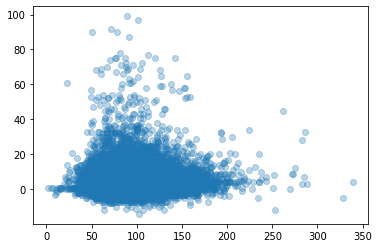

In [112]:
plt.scatter(train['VoronoiAreaNoOffenceRusher'], train['Yards'], alpha=.3)

In [113]:
yards = train.pop('Yards')
season = train.pop('Season')
season_weights = season.map({2017: .8, 2018: 1.2}).values

# Model build

In [114]:
fill_val = -999

In [115]:
X = train.copy()

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

In [116]:
col_order = sorted(train.columns)
X = X[col_order]
scaler = StandardScaler()
X = scaler.fit_transform(X.fillna(fill_val))

In [117]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [118]:
def get_model(x_tr,y_tr,x_val,y_val,w_tr):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dropout(0.35)(inp)
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=[]
    )

    es = EarlyStopping(
        monitor='CRPS_score_val', 
        mode='min',
        restore_best_weights=True, 
        verbose=1, 
        patience=10
    )

    mc = ModelCheckpoint(
        'best_model.h5',
        monitor='CRPS_score_val',
        mode='min',
        save_best_only=True, 
        verbose=1, 
        save_weights_only=True
    )
    
    bsz = 1024
    steps = x_tr.shape[0] / bsz
    
    model.fit(
        x_tr, 
        y_tr,
        callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
        epochs=100, 
        batch_size=bsz,
        sample_weight=w_tr,
        verbose=1
    )
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)

    return model,crps

In [119]:
losses = []
models = []
crps_csv = []
s_time = time.time()

for k in range(2):
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.15, random_state=SEED + k)
    kfold = KFold(5, random_state=SEED + k, shuffle=True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards)):
        print("-----------")
        print("-----------")
        tr_x, tr_y = X[tr_inds],y[tr_inds]
        val_x, val_y = X[val_inds],y[val_inds]
        w_tr = season_weights[tr_inds]
        model,crps = get_model(tr_x,tr_y,val_x,val_y,w_tr)
        models.append(model)
        print("the %d fold crps is %f"%((k_fold+1),crps))
        crps_csv.append(crps)

print("mean crps is %f"%np.mean(crps_csv))

def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te, batch_size=1024)
        else:
            y_pred += m.predict(x_te, batch_size=1024)
            
    y_pred = y_pred / model_num
    
    return y_pred

-----------
-----------
validation shape 2
Epoch 1/100
18536/18536 [==============================] - 4s 220us/step - loss: 5.6135

Epoch 00001: CRPS_score_val improved from inf to 0.07983, saving model to best_model.h5
Epoch 2/100
18536/18536 [==============================] - 3s 163us/step - loss: 5.1457

Epoch 00002: CRPS_score_val improved from 0.07983 to 0.07537, saving model to best_model.h5
Epoch 3/100
18536/18536 [==============================] - 3s 164us/step - loss: 4.7173

Epoch 00003: CRPS_score_val improved from 0.07537 to 0.07048, saving model to best_model.h5
Epoch 4/100
18536/18536 [==============================] - 3s 174us/step - loss: 4.2738

Epoch 00004: CRPS_score_val improved from 0.07048 to 0.05821, saving model to best_model.h5
Epoch 5/100
18536/18536 [==============================] - 3s 165us/step - loss: 3.8682

Epoch 00005: CRPS_score_val improved from 0.05821 to 0.03442, saving model to best_model.h5
Epoch 6/100
18536/18536 [==============================]

18536/18536 [==============================] - 11s 591us/step - loss: 2.5708

Epoch 00049: CRPS_score_val did not improve from 0.01332
Epoch 50/100
18536/18536 [==============================] - 8s 436us/step - loss: 2.5538

Epoch 00050: CRPS_score_val did not improve from 0.01332
Epoch 51/100
18536/18536 [==============================] - 11s 608us/step - loss: 2.5631
Restoring model weights from the end of the best epoch

Epoch 00051: CRPS_score_val did not improve from 0.01332
Epoch 00051: early stopping
the 1 fold crps is 0.013324
-----------
-----------
validation shape 2
Epoch 1/100
18537/18537 [==============================] - 6s 347us/step - loss: 5.5956

Epoch 00001: CRPS_score_val improved from inf to 0.07687, saving model to best_model.h5
Epoch 2/100
18537/18537 [==============================] - 5s 253us/step - loss: 5.1232

Epoch 00002: CRPS_score_val did not improve from 0.07687
Epoch 3/100
18537/18537 [==============================] - 4s 226us/step - loss: 4.6690

Epoc

18537/18537 [==============================] - 3s 171us/step - loss: 2.5680

Epoch 00046: CRPS_score_val did not improve from 0.01305
Epoch 47/100
18537/18537 [==============================] - 6s 317us/step - loss: 2.5815

Epoch 00047: CRPS_score_val did not improve from 0.01305
Epoch 48/100
18537/18537 [==============================] - 6s 298us/step - loss: 2.5659

Epoch 00048: CRPS_score_val did not improve from 0.01305
Epoch 49/100
18537/18537 [==============================] - 12s 647us/step - loss: 2.5698

Epoch 00049: CRPS_score_val did not improve from 0.01305
Epoch 50/100
18537/18537 [==============================] - 5s 283us/step - loss: 2.5561

Epoch 00050: CRPS_score_val did not improve from 0.01305
Epoch 51/100
18537/18537 [==============================] - 4s 236us/step - loss: 2.5527

Epoch 00051: CRPS_score_val did not improve from 0.01305
Epoch 52/100
18537/18537 [==============================] - 4s 227us/step - loss: 2.5530
Restoring model weights from the end of t

18537/18537 [==============================] - 4s 218us/step - loss: 2.6110

Epoch 00041: CRPS_score_val improved from 0.01276 to 0.01274, saving model to best_model.h5
Epoch 42/100
18537/18537 [==============================] - 4s 227us/step - loss: 2.6008

Epoch 00042: CRPS_score_val did not improve from 0.01274
Epoch 43/100
18537/18537 [==============================] - 4s 202us/step - loss: 2.5904

Epoch 00043: CRPS_score_val did not improve from 0.01274
Epoch 44/100
18537/18537 [==============================] - 3s 187us/step - loss: 2.5908

Epoch 00044: CRPS_score_val did not improve from 0.01274
Epoch 45/100
18537/18537 [==============================] - 4s 191us/step - loss: 2.5868

Epoch 00045: CRPS_score_val improved from 0.01274 to 0.01274, saving model to best_model.h5
Epoch 46/100
18537/18537 [==============================] - 4s 213us/step - loss: 2.5844

Epoch 00046: CRPS_score_val improved from 0.01274 to 0.01272, saving model to best_model.h5
Epoch 47/100
18537/18537 [

18537/18537 [==============================] - 5s 263us/step - loss: 2.6852

Epoch 00027: CRPS_score_val improved from 0.01214 to 0.01213, saving model to best_model.h5
Epoch 28/100
18537/18537 [==============================] - 5s 245us/step - loss: 2.6752

Epoch 00028: CRPS_score_val improved from 0.01213 to 0.01210, saving model to best_model.h5
Epoch 29/100
18537/18537 [==============================] - 6s 303us/step - loss: 2.6737

Epoch 00029: CRPS_score_val did not improve from 0.01210
Epoch 30/100
18537/18537 [==============================] - 5s 295us/step - loss: 2.6665

Epoch 00030: CRPS_score_val did not improve from 0.01210
Epoch 31/100
18537/18537 [==============================] - 5s 282us/step - loss: 2.6687

Epoch 00031: CRPS_score_val did not improve from 0.01210
Epoch 32/100
18537/18537 [==============================] - 6s 297us/step - loss: 2.6652

Epoch 00032: CRPS_score_val improved from 0.01210 to 0.01210, saving model to best_model.h5
Epoch 33/100
18537/18537 [

18537/18537 [==============================] - 4s 215us/step - loss: 2.8595

Epoch 00011: CRPS_score_val improved from 0.01303 to 0.01290, saving model to best_model.h5
Epoch 12/100
18537/18537 [==============================] - 4s 205us/step - loss: 2.8298

Epoch 00012: CRPS_score_val improved from 0.01290 to 0.01285, saving model to best_model.h5
Epoch 13/100
18537/18537 [==============================] - 5s 266us/step - loss: 2.8016

Epoch 00013: CRPS_score_val improved from 0.01285 to 0.01281, saving model to best_model.h5
Epoch 14/100
18537/18537 [==============================] - 3s 186us/step - loss: 2.7787

Epoch 00014: CRPS_score_val improved from 0.01281 to 0.01278, saving model to best_model.h5
Epoch 15/100
18537/18537 [==============================] - 3s 182us/step - loss: 2.7748

Epoch 00015: CRPS_score_val improved from 0.01278 to 0.01274, saving model to best_model.h5
Epoch 16/100
18537/18537 [==============================] - 3s 169us/step - loss: 2.7606

Epoch 00016: 

18537/18537 [==============================] - 3s 161us/step - loss: 2.5307

Epoch 00060: CRPS_score_val did not improve from 0.01244
Epoch 61/100
18537/18537 [==============================] - 3s 157us/step - loss: 2.5273

Epoch 00061: CRPS_score_val did not improve from 0.01244
Epoch 62/100
18537/18537 [==============================] - 3s 159us/step - loss: 2.5205

Epoch 00062: CRPS_score_val did not improve from 0.01244
Epoch 63/100
18537/18537 [==============================] - 3s 156us/step - loss: 2.5053

Epoch 00063: CRPS_score_val did not improve from 0.01244
Epoch 64/100
18537/18537 [==============================] - 3s 162us/step - loss: 2.5119

Epoch 00064: CRPS_score_val did not improve from 0.01244
Epoch 65/100
18537/18537 [==============================] - 3s 178us/step - loss: 2.5084

Epoch 00065: CRPS_score_val did not improve from 0.01244
Epoch 66/100
18537/18537 [==============================] - 3s 159us/step - loss: 2.4946

Epoch 00066: CRPS_score_val did not impro

18536/18536 [==============================] - 3s 154us/step - loss: 2.6069

Epoch 00040: CRPS_score_val improved from 0.01310 to 0.01308, saving model to best_model.h5
Epoch 41/100
18536/18536 [==============================] - 3s 159us/step - loss: 2.6105

Epoch 00041: CRPS_score_val did not improve from 0.01308
Epoch 42/100
18536/18536 [==============================] - 3s 154us/step - loss: 2.6072

Epoch 00042: CRPS_score_val did not improve from 0.01308
Epoch 43/100
18536/18536 [==============================] - 3s 161us/step - loss: 2.6024

Epoch 00043: CRPS_score_val did not improve from 0.01308
Epoch 44/100
18536/18536 [==============================] - 3s 156us/step - loss: 2.5926

Epoch 00044: CRPS_score_val did not improve from 0.01308
Epoch 45/100
18536/18536 [==============================] - 3s 152us/step - loss: 2.5868

Epoch 00045: CRPS_score_val did not improve from 0.01308
Epoch 46/100
18536/18536 [==============================] - 3s 154us/step - loss: 2.5845

Epoch 

18537/18537 [==============================] - 3s 152us/step - loss: 2.6562

Epoch 00032: CRPS_score_val improved from 0.01239 to 0.01237, saving model to best_model.h5
Epoch 33/100
18537/18537 [==============================] - 3s 154us/step - loss: 2.6489

Epoch 00033: CRPS_score_val improved from 0.01237 to 0.01237, saving model to best_model.h5
Epoch 34/100
18537/18537 [==============================] - 3s 153us/step - loss: 2.6483

Epoch 00034: CRPS_score_val improved from 0.01237 to 0.01236, saving model to best_model.h5
Epoch 35/100
18537/18537 [==============================] - 3s 151us/step - loss: 2.6436

Epoch 00035: CRPS_score_val improved from 0.01236 to 0.01235, saving model to best_model.h5
Epoch 36/100
18537/18537 [==============================] - 3s 154us/step - loss: 2.6427

Epoch 00036: CRPS_score_val improved from 0.01235 to 0.01234, saving model to best_model.h5
Epoch 37/100
18537/18537 [==============================] - 3s 156us/step - loss: 2.6315

Epoch 00037: 

18537/18537 [==============================] - 3s 179us/step - loss: 2.7205

Epoch 00020: CRPS_score_val improved from 0.01283 to 0.01281, saving model to best_model.h5
Epoch 21/100
18537/18537 [==============================] - 3s 172us/step - loss: 2.7095

Epoch 00021: CRPS_score_val did not improve from 0.01281
Epoch 22/100
18537/18537 [==============================] - 3s 177us/step - loss: 2.7092

Epoch 00022: CRPS_score_val did not improve from 0.01281
Epoch 23/100
18537/18537 [==============================] - 4s 197us/step - loss: 2.6955

Epoch 00023: CRPS_score_val improved from 0.01281 to 0.01280, saving model to best_model.h5
Epoch 24/100
18537/18537 [==============================] - 3s 175us/step - loss: 2.6923

Epoch 00024: CRPS_score_val improved from 0.01280 to 0.01279, saving model to best_model.h5
Epoch 25/100
18537/18537 [==============================] - 5s 255us/step - loss: 2.6844

Epoch 00025: CRPS_score_val improved from 0.01279 to 0.01278, saving model to best_

18537/18537 [==============================] - 3s 171us/step - loss: 3.2121

Epoch 00007: CRPS_score_val improved from 0.01989 to 0.01508, saving model to best_model.h5
Epoch 8/100
18537/18537 [==============================] - 553s 30ms/step - loss: 3.0494

Epoch 00008: CRPS_score_val improved from 0.01508 to 0.01383, saving model to best_model.h5
Epoch 9/100
18537/18537 [==============================] - 4s 222us/step - loss: 2.9436

Epoch 00009: CRPS_score_val improved from 0.01383 to 0.01330, saving model to best_model.h5
Epoch 10/100
18537/18537 [==============================] - 3s 167us/step - loss: 2.8818

Epoch 00010: CRPS_score_val improved from 0.01330 to 0.01306, saving model to best_model.h5
Epoch 11/100
18537/18537 [==============================] - 3s 163us/step - loss: 2.8369

Epoch 00011: CRPS_score_val improved from 0.01306 to 0.01299, saving model to best_model.h5
Epoch 12/100
18537/18537 [==============================] - 3s 164us/step - loss: 2.8158

Epoch 00012: C

18537/18537 [==============================] - 3s 165us/step - loss: 3.8511

Epoch 00005: CRPS_score_val improved from 0.05978 to 0.03630, saving model to best_model.h5
Epoch 6/100
18537/18537 [==============================] - 3s 158us/step - loss: 3.4907

Epoch 00006: CRPS_score_val improved from 0.03630 to 0.02213, saving model to best_model.h5
Epoch 7/100
18537/18537 [==============================] - 3s 162us/step - loss: 3.2342

Epoch 00007: CRPS_score_val improved from 0.02213 to 0.01578, saving model to best_model.h5
Epoch 8/100
18537/18537 [==============================] - 3s 171us/step - loss: 3.0508

Epoch 00008: CRPS_score_val improved from 0.01578 to 0.01426, saving model to best_model.h5
Epoch 9/100
18537/18537 [==============================] - 3s 176us/step - loss: 2.9537

Epoch 00009: CRPS_score_val improved from 0.01426 to 0.01366, saving model to best_model.h5
Epoch 10/100
18537/18537 [==============================] - 3s 186us/step - loss: 2.8786

Epoch 00010: CRPS

In [120]:
print("mean crps is %f"%np.mean(crps_csv))

mean crps is 0.012706


In [27]:
from kaggle.competitions import nflrush

names = dict(zip(range(199), ['Yards%d' % i for i in range(-99, 100)]))

env = nflrush.make_env()
for i, (df_test, sample_pred) in enumerate(env.iter_test()):
    test = processor.initial_cleaning(df_test)
    test = processor.transform(test) 
    #test = dropper.transform(test)
    
    for col in col_order:
        if col not in test.columns:
            test[col] = 0
    
    test = test[col_order]
    scaled_test = scaler.transform(test.fillna(fill_val))   
    y_pred = predict(scaled_test)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

    preds_df = pd.DataFrame(data=[y_pred], columns=sample_pred.columns)
    if i == 0:
        all_preds = preds_df
        all_test_rows = test
    else:
        all_preds = pd.concat([all_preds, preds_df], ignore_index=True, sort=False)
        all_test_rows = pd.concat([all_test_rows, test], ignore_index=True, sort=False)
    env.predict(preds_df)
all_test_rows.to_csv('X_test.csv')
env.write_submission_file()


INITIAL_CLEANING
 -- _correct_team_abbreviations -- 
	shape = (22, 48)
	null % = 2.08
 -- _encode_player_height -- 
	shape = (22, 48)
	null % = 2.08
 -- _process_time_variables -- 
	shape = (22, 48)
	null % = 2.08
 -- _fix_wind_variables -- 
	shape = (22, 48)
	null % = 2.08
 -- _fix_stadium_type_and_turf -- 
	shape = (22, 48)
	null % = 2.08
 -- _map_college_and_pos -- 
	shape = (22, 51)
	null % = 1.96
 -- _encode_personnel -- 
	shape = (22, 61)
	null % = 1.64
 -- _normalise_positional_data -- 
	shape = (22, 72)
	null % = 1.39
 -- _calc_voronoi -- 
	shape = (22, 74)
	null % = 1.35
 -- _misc_engineering -- 
	shape = (22, 101)
	null % = 0.99
initial_cleaning time taken: 0.00 mins

TRANSFORM
 -- _apply_one_hot_encoder -- 
	dropping columns: DisplayName GameWeather Location Stadium HomeTeamAbbr VisitorTeamAbbr for having cardinality > 24
	one hot encoding columns: WindDirection StadiumType OffenseFormation CollegeConference PositionRusher
	shape = (22, 140)
	null % = 0.00
 -- _flatten_play